# 0. Reading data

In [385]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from datetime import datetime
from sklearn.metrics import roc_auc_score, roc_curve, auc
import category_encoders as ce

import math
from pyarrow.parquet import ParquetFile
import pyarrow.parquet as pq
import pickle
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance
from xgboost import cv
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
import hyperopt
import shap
import mlflow
from sklearn.inspection import permutation_importance
from sklearn.calibration import calibration_curve
from sklearn.isotonic import IsotonicRegression

In [386]:
df = pd.read_csv(r"C:\Users\radkr\Downloads\klarnaclassificationcase-1-\klarnaclassificationcase\mlcasestudy.csv")

# 1. EAD 

In [387]:
df.head(3)

,loan_id,loan_issue_date,loan_amount,amount_outstanding_14d,amount_outstanding_21d,card_expiry_month,card_expiry_year,existing_klarna_debt,num_active_loans,days_since_first_loan,...,num_failed_payments_3m,num_failed_payments_6m,num_failed_payments_1y,amount_repaid_14d,amount_repaid_1m,amount_repaid_3m,amount_repaid_6m,amount_repaid_1y,merchant_group,merchant_category
0,a55cf3062bd45a83766096fd0c4697d6,2023-06-24,5300,0,0,2.0,2026.0,21098.0,2,717,...,0,0,0,6875,15580,42325,67878,152193,Clothing & Shoes,Adult Shoes & Clothing
1,45e3d15cb313d767470722e952e14313,2023-09-22,9547,7161,7161,6.0,2027.0,NaN,0,-1,...,0,0,0,0,0,0,0,0,"Leisure, Sport & Hobby",Concept Stores & Miscellaneous
2,b195c127c7605b7b936b90bcdb5e889c,2023-07-03,5948,0,0,12.0,2023.0,NaN,0,-1,...,0,0,0,0,0,0,0,0,Clothing & Shoes,General Shoes & Clothing


In [388]:
df.describe()

,loan_amount,amount_outstanding_14d,amount_outstanding_21d,card_expiry_month,card_expiry_year,existing_klarna_debt,num_active_loans,days_since_first_loan,new_exposure_7d,new_exposure_14d,num_confirmed_payments_3m,num_confirmed_payments_6m,num_failed_payments_3m,num_failed_payments_6m,num_failed_payments_1y,amount_repaid_14d,amount_repaid_1m,amount_repaid_3m,amount_repaid_6m,amount_repaid_1y
count,111902.000000,111902.000000,111902.000000,111747.000000,111747.000000,82690.000000,111902.000000,111902.000000,111902.000000,111902.000000,111902.000000,111902.000000,111902.000000,111902.000000,111902.000000,111902.000000,111902.000000,1.119020e+05,1.119020e+05,1.119020e+05
mean,17574.472923,783.980912,427.414506,6.558717,2026.075751,16018.206555,0.698361,294.849368,3555.791255,4895.849332,4.192758,7.309708,0.032001,0.103609,0.220505,2579.486649,5177.577648,1.367431e+04,2.384821e+04,3.905965e+04
std,23187.429786,3870.216199,3287.967065,3.343516,1.510035,33369.756130,1.420218,346.801391,12253.573859,14762.162492,8.798458,15.233768,0.325918,0.756232,1.458168,6582.401240,12532.816206,3.042412e+04,5.261774e+04,8.577351e+04
min,102.000000,0.000000,0.000000,1.000000,2023.000000,-220618.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
25%,6160.000000,0.000000,0.000000,4.000000,2025.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
50%,10877.000000,0.000000,0.000000,6.000000,2026.000000,1404.000000,0.000000,136.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,3.656500e+03,8.436000e+03
75%,19461.000000,0.000000,0.000000,9.000000,2027.000000,19008.000000,1.000000,546.000000,0.000000,2141.500000,5.000000,8.000000,0.000000,0.000000,0.000000,2490.000000,5406.000000,1.511650e+04,2.681925e+04,4.352300e+04
max,392913.000000,193313.000000,193313.000000,12.000000,2032.000000,817852.000000,61.000000,1095.000000,562297.000000,562297.000000,356.000000,602.000000,17.000000,52.000000,266.000000,214994.000000,531469.000000,1.398723e+06,3.582917e+06,6.985861e+06


In [389]:
df.isna().sum()

loan_id                          0
loan_issue_date                  0
loan_amount                      0
amount_outstanding_14d           0
amount_outstanding_21d           0
card_expiry_month              155
card_expiry_year               155
existing_klarna_debt         29212
num_active_loans                 0
days_since_first_loan            0
new_exposure_7d                  0
new_exposure_14d                 0
num_confirmed_payments_3m        0
num_confirmed_payments_6m        0
num_failed_payments_3m           0
num_failed_payments_6m           0
num_failed_payments_1y           0
amount_repaid_14d                0
amount_repaid_1m                 0
amount_repaid_3m                 0
amount_repaid_6m                 0
amount_repaid_1y                 0
merchant_group                   0
merchant_category                0
dtype: int64

In [390]:
(df.drop(['loan_id', 'card_expiry_month', 'card_expiry_year', 'loan_issue_date', 'merchant_group', 'merchant_category'], axis=1) < 0).sum()

loan_amount                      0
amount_outstanding_14d           0
amount_outstanding_21d           0
existing_klarna_debt            59
num_active_loans                 0
days_since_first_loan        36115
new_exposure_7d                  0
new_exposure_14d                 0
num_confirmed_payments_3m        0
num_confirmed_payments_6m        0
num_failed_payments_3m           0
num_failed_payments_6m           0
num_failed_payments_1y           0
amount_repaid_14d                0
amount_repaid_1m                 0
amount_repaid_3m                 0
amount_repaid_6m                 0
amount_repaid_1y                 0
dtype: int64

In [391]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111902 entries, 0 to 111901
Data columns (total 24 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   loan_id                    111902 non-null  object 
 1   loan_issue_date            111902 non-null  object 
 2   loan_amount                111902 non-null  int64  
 3   amount_outstanding_14d     111902 non-null  int64  
 4   amount_outstanding_21d     111902 non-null  int64  
 5   card_expiry_month          111747 non-null  float64
 6   card_expiry_year           111747 non-null  float64
 7   existing_klarna_debt       82690 non-null   float64
 8   num_active_loans           111902 non-null  int64  
 9   days_since_first_loan      111902 non-null  int64  
 10  new_exposure_7d            111902 non-null  int64  
 11  new_exposure_14d           111902 non-null  int64  
 12  num_confirmed_payments_3m  111902 non-null  int64  
 13  num_confirmed_payments_6m  11

In [392]:
df.shape

(111902, 24)

In [393]:
df['loan_issue_date'] = pd.to_datetime(df['loan_issue_date'])

In [394]:
print(df['loan_issue_date'].min())
print(df['loan_issue_date'].max())

2023-06-01 00:00:00
2023-10-27 00:00:00


In [395]:
df['loan_issue_date'].dt.day_of_week

0         5
1         4
2         0
3         5
4         5
         ..
111897    6
111898    0
111899    1
111900    6
111901    4
Name: loan_issue_date, Length: 111902, dtype: int32

# 2. Feature engineering

## 2.1 Target variable

definition of default -> Inability to repay the loan in 21 days 

Probability of default -> probability of inability to repay the full loan in 21 days (at the moment of issueing the loan)

In [396]:
df['amount_outstanding_21d'].value_counts().sort_index()

amount_outstanding_21d
0         105813
1              3
18             1
27             1
28             1
           ...  
159836         1
162519         1
167870         1
175657         1
193313         1
Name: count, Length: 4526, dtype: int64

In [397]:
df['amount_outstanding_21d'] == 0

0          True
1         False
2          True
3          True
4          True
          ...  
111897     True
111898     True
111899     True
111900     True
111901     True
Name: amount_outstanding_21d, Length: 111902, dtype: bool

In [398]:
df['target'] = np.where(df['amount_outstanding_21d'] == 0, 0, 1)

In [399]:
df['target'].value_counts()

target
0    105813
1      6089
Name: count, dtype: int64

In [400]:
df['target'].mean()

0.054413683401547785

### 2.1.1 day of the week & month

C:\Users\radkr\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\radkr\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\radkr\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\radkr\App

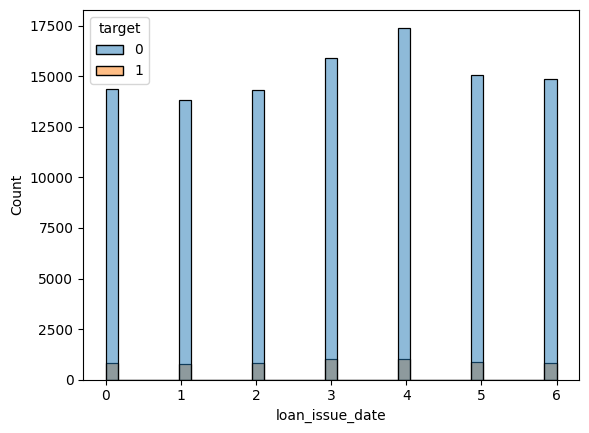

In [401]:
sns.histplot(data = df, x = df['loan_issue_date'].dt.day_of_week, hue = df['target']);

In [402]:
df.groupby(df['loan_issue_date'].dt.day_of_week)['target'].mean().round(4) * 100

loan_issue_date
0    5.31
1    5.43
2    5.36
3    6.00
4    5.45
5    5.34
6    5.15
Name: target, dtype: float64

In [403]:
df.groupby(df['loan_issue_date'].dt.to_period('M'))['target'].mean()

loan_issue_date
2023-06    0.060964
2023-07    0.064660
2023-08    0.056662
2023-09    0.047339
2023-10    0.044400
Freq: M, Name: target, dtype: float64

## 2.2 Loan amount

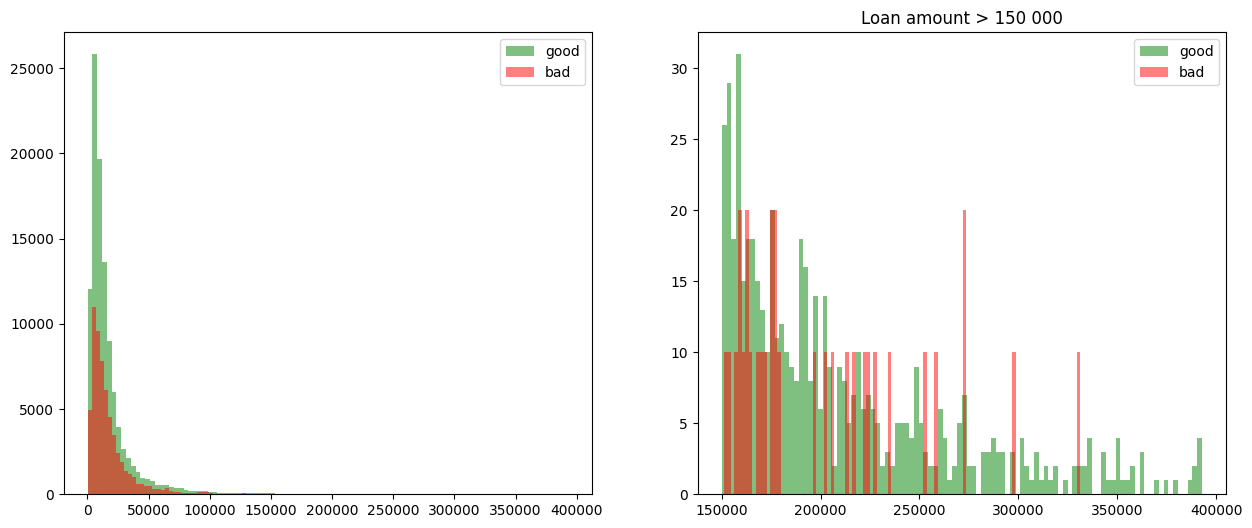

In [404]:
fig, ax = plt.subplots(1,2, figsize = (15,6))

ax[0].hist(df[df['target'] == 0]['loan_amount'], color = 'green', bins = 100, alpha = 0.5, label = 'good')
ax[0].hist(df[df['target'] == 1]['loan_amount'], color = 'red', bins = 100, weights = np.ones(df[df['target'] == 1].shape[0]) * 10, alpha = 0.5, label = 'bad')
ax[0].legend()

ax[1].hist(df[(df['target'] == 0) & (df['loan_amount'] > 150_000)]['loan_amount'], color = 'green', bins = 100, alpha = 0.5, label = 'good')
ax[1].hist(df[(df['target'] == 1) & (df['loan_amount'] > 150_000)]['loan_amount'], color = 'red', bins = 100, weights = np.ones(df[(df['target'] == 1) & (df['loan_amount'] > 150_000)].shape[0]) * 10, alpha = 0.5, label = 'bad')
ax[1].legend()
ax[1].set_title('Loan amount > 150 000')

plt.show()

C:\Users\radkr\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\radkr\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\radkr\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


<Axes: xlabel='loan_amount', ylabel='Count'>

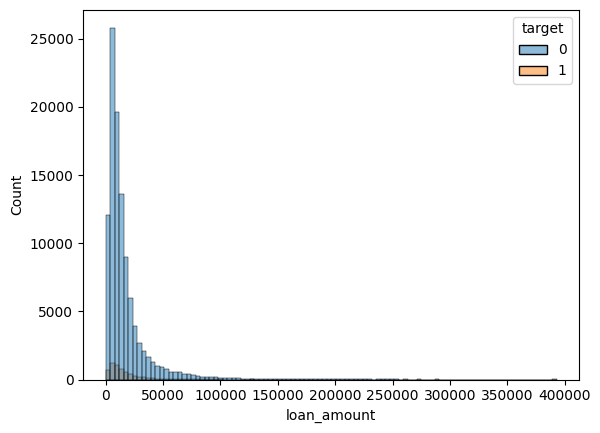

In [405]:
sns.histplot(data=df, x='loan_amount', hue='target', bins = 100)

## 2.3 card_expiry_month & card_expiry_year

In [406]:
card_expiry = pd.to_datetime(pd.DataFrame({'year': df['card_expiry_year'], 'month': df['card_expiry_month'], 'day': 1}))

In [407]:
card_expiry

0        2026-02-01
1        2027-06-01
2        2023-12-01
3        2026-02-01
4        2026-08-01
            ...    
111897   2027-09-01
111898   2027-03-01
111899   2025-03-01
111900   2027-05-01
111901   2027-11-01
Length: 111902, dtype: datetime64[ns]

In [408]:
df['card_expiry_days'] = (card_expiry - df['loan_issue_date']).dt.days

In [409]:
df = df.drop(['card_expiry_year', 'card_expiry_month', 'amount_outstanding_21d', 'amount_outstanding_14d'], axis = 1)

## 2.4 existing_klarna_debt

C:\Users\radkr\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\radkr\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\radkr\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


<Axes: xlabel='existing_klarna_debt', ylabel='Count'>

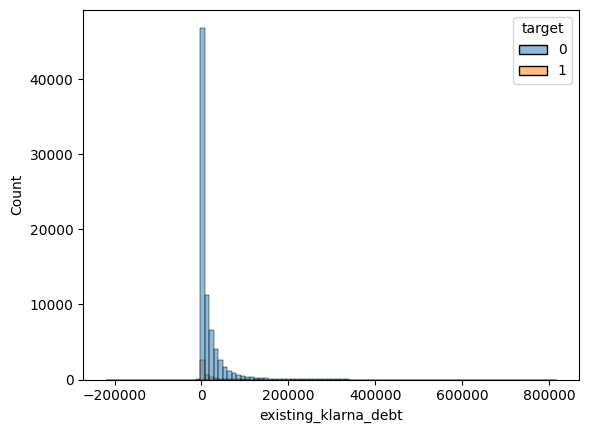

In [410]:
sns.histplot(data=df, x='existing_klarna_debt', hue='target', bins = 100)

In [411]:
df[df['existing_klarna_debt'].isna()].head(2)

,loan_id,loan_issue_date,loan_amount,existing_klarna_debt,num_active_loans,days_since_first_loan,new_exposure_7d,new_exposure_14d,num_confirmed_payments_3m,num_confirmed_payments_6m,...,num_failed_payments_1y,amount_repaid_14d,amount_repaid_1m,amount_repaid_3m,amount_repaid_6m,amount_repaid_1y,merchant_group,merchant_category,target,card_expiry_days
1,45e3d15cb313d767470722e952e14313,2023-09-22,9547,NaN,0,-1,0,0,0,0,...,0,0,0,0,0,0,"Leisure, Sport & Hobby",Concept Stores & Miscellaneous,1,1348.0
2,b195c127c7605b7b936b90bcdb5e889c,2023-07-03,5948,NaN,0,-1,0,0,0,0,...,0,0,0,0,0,0,Clothing & Shoes,General Shoes & Clothing,0,151.0


In [412]:
df['target'].mean()

0.054413683401547785

In [413]:
df[df['existing_klarna_debt'].isna()]['target'].mean()

0.06610297138162399

In [414]:
df[df['existing_klarna_debt'] < 0]['target'].mean()

0.0847457627118644

In [415]:
df[df['existing_klarna_debt'] == 0]['target'].mean()

0.05470077053740676

insight: Clients with Null debts have higher default risks than those with either debt or no debt at all.

No need for feature engineering for tree-based models, however regression based models would require it.

## 2.4 num_active_loans

C:\Users\radkr\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\radkr\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\radkr\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


<Axes: xlabel='num_active_loans', ylabel='Count'>

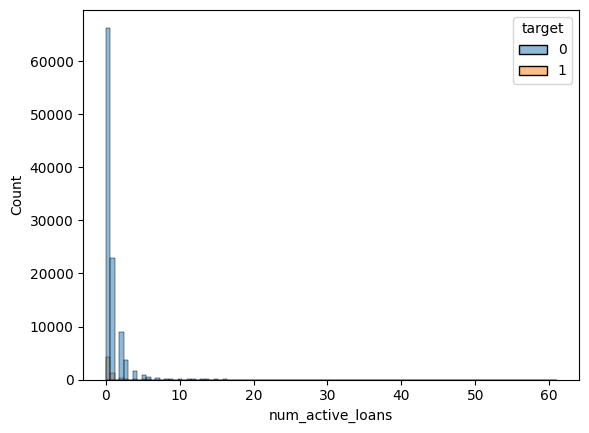

In [416]:
sns.histplot(data=df, x='num_active_loans', hue='target', bins = 100)

In [417]:
df[df['num_active_loans'] < 0].shape[0]

0

## 2.5 days_since_first_loan

C:\Users\radkr\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\radkr\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\radkr\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


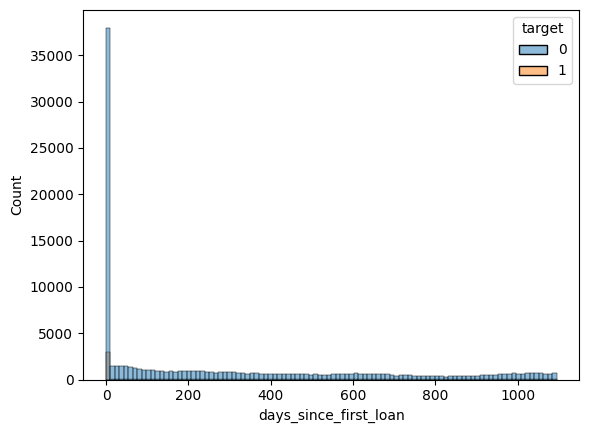

In [418]:
sns.histplot(data=df, x='days_since_first_loan', hue='target', bins = 100);


C:\Users\radkr\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\radkr\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\radkr\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


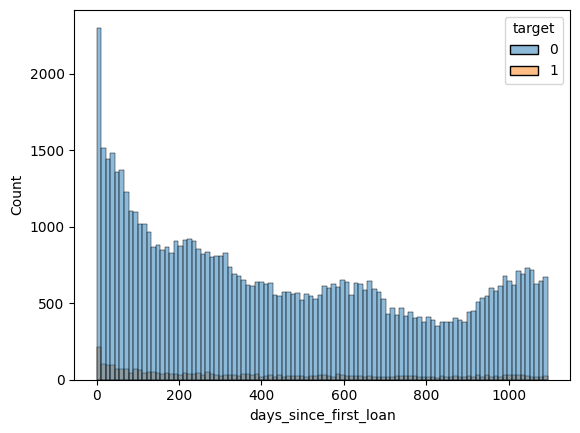

In [419]:
sns.histplot(data=df[df['days_since_first_loan'] > 0], x='days_since_first_loan', hue='target', bins = 100);

C:\Users\radkr\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\radkr\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\radkr\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


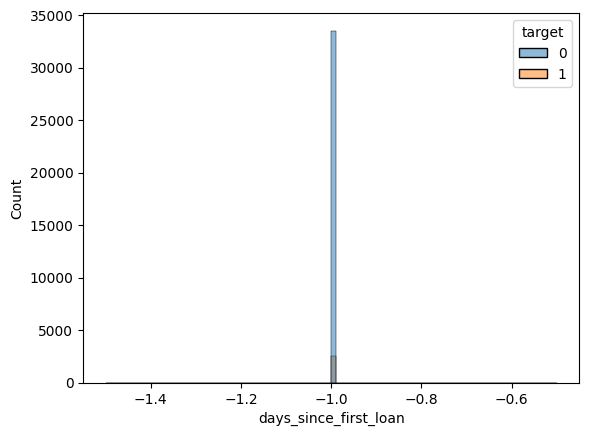

In [420]:
sns.histplot(data=df[df['days_since_first_loan'] < 0], x='days_since_first_loan', hue='target', bins = 100);

In [421]:
df[df['days_since_first_loan'] < 0].shape[0]

36115

In [422]:
df[df['days_since_first_loan']< 0]['target'].mean()

0.07135539249619272

In [423]:
df[df['days_since_first_loan']>= 0]['target'].mean()

0.04634040138810086

There is a significantly higher risk for clients with negative **days_since_first_loan** -> the variable remains unchanged.
If this were corrupted data (e.g. due to data leakege), those values should have been transformed. However, since we are not certain, the variable remains the same.

## 2.7 new exposure

C:\Users\radkr\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\radkr\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\radkr\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\radkr\App

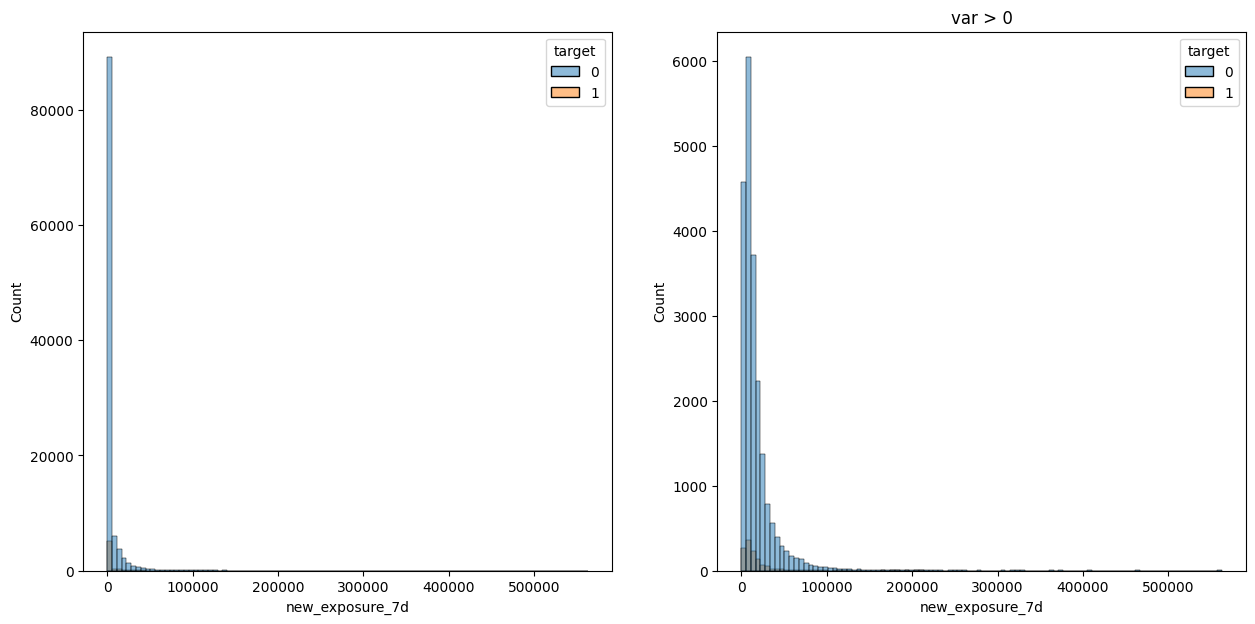

C:\Users\radkr\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\radkr\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\radkr\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\radkr\App

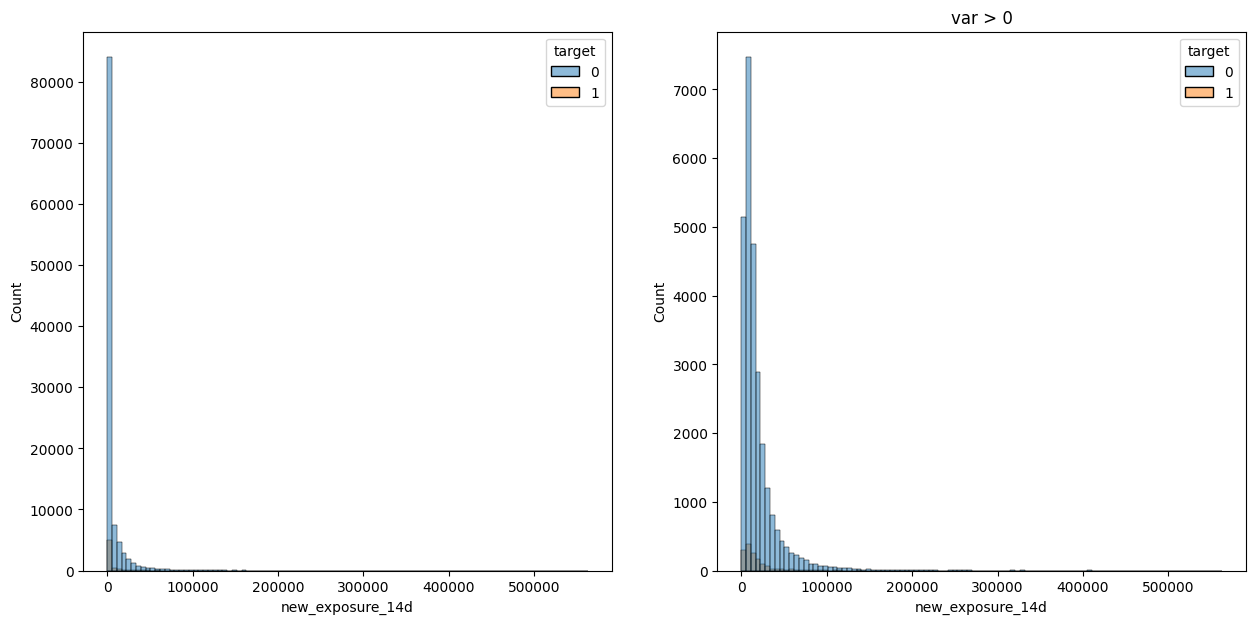

In [424]:
vars = ['new_exposure_7d', 'new_exposure_14d']

for v in vars:
    fig, ax = plt.subplots(1,2, figsize=(15,7))
    sns.histplot(data=df, x=v, hue='target', bins = 100, ax = ax[0])
    sns.histplot(data=df[df[v] > 0], x=v, hue='target', bins = 100, ax = ax[1])
    ax[1].set_title('var > 0')
    plt.show()

In [425]:
vars = ['new_exposure_7d', 'new_exposure_14d']

for v in vars:
    print(v, df[v].mean())

new_exposure_7d 3555.791254847992
new_exposure_14d 4895.849332451609


In [426]:
2 * roc_auc_score(df['target'], df['new_exposure_7d']) - 1

0.0015614407104906913

In [427]:
2 * roc_auc_score(df['target'], df['new_exposure_14d']) - 1

-0.020175274986499625

In [428]:
np.where((df['new_exposure_7d']/df['new_exposure_14d']).isna(), 0, df['new_exposure_7d']/df['new_exposure_14d'])

array([0., 0., 0., ..., 1., 0., 0.])

In [429]:
2 * roc_auc_score(df['target'], 
                  np.where((df['new_exposure_7d']/df['new_exposure_14d']).isna(), 0, df['new_exposure_7d']/df['new_exposure_14d'])
) - 1

0.003994258179948362

In [430]:
2 * roc_auc_score(df['target'], df['new_exposure_7d'] - df['new_exposure_14d']) - 1

0.029389581648032737

In [431]:
df['new_exposure_7d_14d'] = df['new_exposure_7d'] - df['new_exposure_14d']

## 2.8 payments

In [432]:
df['num_failed_payments_3m_1y'] = (df['num_failed_payments_3m'] / df['num_failed_payments_1y']).fillna(0)

C:\Users\radkr\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\radkr\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\radkr\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


<Axes: xlabel='num_failed_payments_3m_1y', ylabel='Count'>

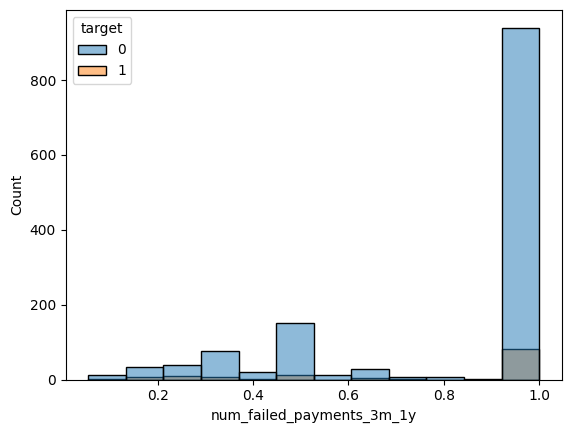

In [433]:
sns.histplot(data = df[df['num_failed_payments_3m_1y'] > 0], x = 'num_failed_payments_3m_1y', hue = 'target')

In [434]:
df['num_failed_payments_3m_6m'] = (df['num_failed_payments_3m'] / df['num_failed_payments_6m']).fillna(0)

## 2.9 repaid

In [435]:
vars = ['amount_repaid_14d', 'amount_repaid_1m', 'amount_repaid_3m', 'amount_repaid_6m', 'amount_repaid_1y']



In [436]:
df['amount_repaid_14d_1m'] = (df['amount_repaid_14d'] / df['amount_repaid_1m']).fillna(0)
df['amount_repaid_14d_3m'] = (df['amount_repaid_14d'] / df['amount_repaid_3m']).fillna(0)
df['amount_repaid_14d_6m'] = (df['amount_repaid_14d'] / df['amount_repaid_6m']).fillna(0)
df['amount_repaid_14d_1y'] = (df['amount_repaid_14d'] / df['amount_repaid_1y']).fillna(0)
df['amount_repaid_3m_6m'] = (df['amount_repaid_3m'] / df['amount_repaid_6m']).fillna(0)
df['amount_repaid_3m_1y'] = (df['amount_repaid_3m'] / df['amount_repaid_1y']).fillna(0)
df['amount_repaid_6m_1y'] = (df['amount_repaid_6m'] / df['amount_repaid_1y']).fillna(0)



## 2.9 merchant

In [437]:
df.loc[:, ['merchant_group', 'merchant_category']]

,merchant_group,merchant_category
0,Clothing & Shoes,Adult Shoes & Clothing
1,"Leisure, Sport & Hobby",Concept Stores & Miscellaneous
2,Clothing & Shoes,General Shoes & Clothing
3,Clothing & Shoes,Youthful Shoes & Clothing
4,"Leisure, Sport & Hobby",Sports Gear & Outdoor
...,...,...
111897,Intangible products,Event - Broker & Agencies
111898,Clothing & Shoes,General Shoes & Clothing
111899,Clothing & Shoes,General Shoes & Clothing
111900,Jewelry & Accessories,Jewelry & Watches


In [438]:
df['merchant_group'].unique()

array(['Clothing & Shoes', 'Leisure, Sport & Hobby',
       'Jewelry & Accessories', 'Children Products', 'Food & Beverage',
       'Intangible products', 'Home & Garden', 'Electronics',
       'Health & Beauty', 'Unknown', 'Erotic Materials',
       'Automotive Products', 'Entertainment'], dtype=object)

In [439]:
df.groupby('merchant_group')['target'].mean().round(4) * 100

merchant_group
Automotive Products       4.48
Children Products         4.28
Clothing & Shoes          5.87
Electronics               4.38
Entertainment             4.76
Erotic Materials          4.42
Food & Beverage           7.61
Health & Beauty           5.27
Home & Garden             3.96
Intangible products       6.26
Jewelry & Accessories     3.71
Leisure, Sport & Hobby    3.43
Unknown                   3.50
Name: target, dtype: float64

In [440]:
df.groupby('merchant_group')['merchant_group'].size().sort_values(ascending= False)

merchant_group
Clothing & Shoes          64623
Intangible products       15728
Leisure, Sport & Hobby     9397
Jewelry & Accessories      8067
Home & Garden              4090
Health & Beauty            3680
Electronics                2193
Food & Beverage            2088
Unknown                    1284
Children Products           327
Erotic Materials            249
Automotive Products         134
Entertainment                42
Name: merchant_group, dtype: int64

In [441]:
df['merchant_category'].nunique()

63

In [442]:
df['merchant_category'].drop_duplicates().to_frame().sort_values('merchant_category')

,merchant_category
0,Adult Shoes & Clothing
1302,Automotive Parts & Accessories
237,Bags & Wallets
80,Body & Haircare
30279,Books & Magazines
...,...
5285,Underwear
278,Unknown
7934,Video Games & Related Accessories
1057,Wheels & Tires


In [443]:
df.groupby(['merchant_category', 'merchant_group']).size()

merchant_category                  merchant_group       
Adult Shoes & Clothing             Clothing & Shoes          9072
Automotive Parts & Accessories     Automotive Products         83
Bags & Wallets                     Jewelry & Accessories      174
Body & Haircare                    Health & Beauty           1483
Books & Magazines                  Entertainment               15
                                                            ...  
Underwear                          Clothing & Shoes            55
Unknown                            Unknown                   1284
Video Games & Related Accessories  Entertainment                3
Wheels & Tires                     Automotive Products         51
Youthful Shoes & Clothing          Clothing & Shoes         17621
Length: 63, dtype: int64

In [444]:
(
    df.groupby('merchant_category')
      .agg(count=('merchant_category', 'size'),
           BR=('target', 'mean'))
      .sort_values('count', ascending=False)
      .head(10)
)

,count,BR
merchant_category,,
General Shoes & Clothing,37875,0.052990
Youthful Shoes & Clothing,17621,0.080529
Adult Shoes & Clothing,9072,0.040454
Event - Broker & Agencies,6499,0.046469
Travel - Accommodation & Resorts,6314,0.074438
Diversified Jewelry & Accessories,6143,0.032883
Concept Stores & Miscellaneous,4536,0.033510
Sports Gear & Outdoor,4283,0.035956
Food & Beverage,2055,0.076886


In [445]:
(
    df.groupby('merchant_category')
      .agg(count=('merchant_category', 'size'),
           BR=('target', 'mean'))
      .sort_values('count', ascending=False)
      .tail(50)
)

,count,BR
merchant_category,,
Jewelry & Watches,1168,0.056507
Diversified Electronics,1091,0.040330
Electronic Equipment & Related Accessories,1008,0.044643
Cosmetics,860,0.034884
Travel - Broker & Agencies,641,0.112324
Event Tickets,609,0.060755
Other Services,590,0.066102
Non-Prescription Sunglasses & Contact Lenses,582,0.044674
Digital Services,516,0.073643


Insight: different categories have varying BRs -> this is an impactful variable. We apply target encoding. To limit overfitting, we assign a new category - **Other** to every group with < 50 samples in the full dataset.

Target encoding will be performed on DEV set after sample splitting.

In [446]:
df['merchant_category'].drop_duplicates()[df['merchant_category'].drop_duplicates().str.startswith('O')]

149                                        Other Services
2490    Office Machines & Related Accessories (Excl. C...
Name: merchant_category, dtype: object

In [447]:
# Step 1: Compute the grouped aggregation
df_agg = (
    df.groupby('merchant_category')
      .agg(count=('merchant_category', 'size')
))

# Step 2: Filter categories with count ≤ 50 and get their names as a list
low_volume_categories = df_agg[df_agg['count'] <= 50].index.tolist()

print(low_volume_categories)


['Books & Magazines', 'Candy', 'Car Electronics', 'Cleaning & Sanitary', 'Collectibles', 'Costumes & Party Supplies', 'Diversified Entertainment', 'Diversified Health & Beauty Products', 'Erotic Clothing & Accessories', 'Marketplaces', 'Music & Movies', 'Office Machines & Related Accessories (Excl. Computers)', 'Prints & Photos', 'Safety Products', 'Tobacco', 'Travel Services', 'Video Games & Related Accessories']


In [448]:
len(low_volume_categories)

17

In [449]:
df['merchant_category_encoded'] = np.where(df['merchant_category'].isin(low_volume_categories), 'Other', df['merchant_category'])

In [450]:
# check
(
    df.groupby('merchant_category_encoded')
      .agg(count=('merchant_category_encoded', 'size'),
           BR=('target', 'mean'))
      .sort_values('count', ascending=False)
      .tail(50)
)

,count,BR
merchant_category_encoded,,
General Shoes & Clothing,37875,0.052990
Youthful Shoes & Clothing,17621,0.080529
Adult Shoes & Clothing,9072,0.040454
Event - Broker & Agencies,6499,0.046469
Travel - Accommodation & Resorts,6314,0.074438
Diversified Jewelry & Accessories,6143,0.032883
Concept Stores & Miscellaneous,4536,0.033510
Sports Gear & Outdoor,4283,0.035956
Food & Beverage,2055,0.076886


In [451]:
dummies = pd.get_dummies(df['merchant_group'], dtype=int)

In [452]:
df.columns

Index(['loan_id', 'loan_issue_date', 'loan_amount', 'existing_klarna_debt',
       'num_active_loans', 'days_since_first_loan', 'new_exposure_7d',
       'new_exposure_14d', 'num_confirmed_payments_3m',
       'num_confirmed_payments_6m', 'num_failed_payments_3m',
       'num_failed_payments_6m', 'num_failed_payments_1y', 'amount_repaid_14d',
       'amount_repaid_1m', 'amount_repaid_3m', 'amount_repaid_6m',
       'amount_repaid_1y', 'merchant_group', 'merchant_category', 'target',
       'card_expiry_days', 'new_exposure_7d_14d', 'num_failed_payments_3m_1y',
       'num_failed_payments_3m_6m', 'amount_repaid_14d_1m',
       'amount_repaid_14d_3m', 'amount_repaid_14d_6m', 'amount_repaid_14d_1y',
       'amount_repaid_3m_6m', 'amount_repaid_3m_1y', 'amount_repaid_6m_1y',
       'merchant_category_encoded'],
      dtype='object')

In [453]:
df = df.drop(['merchant_group', 'merchant_category'], axis = 1)

In [454]:
final_df = pd.concat([df, dummies], axis=1)

In [455]:
final_df.head(2)

,loan_id,loan_issue_date,loan_amount,existing_klarna_debt,num_active_loans,days_since_first_loan,new_exposure_7d,new_exposure_14d,num_confirmed_payments_3m,num_confirmed_payments_6m,...,Electronics,Entertainment,Erotic Materials,Food & Beverage,Health & Beauty,Home & Garden,Intangible products,Jewelry & Accessories,"Leisure, Sport & Hobby",Unknown
0,a55cf3062bd45a83766096fd0c4697d6,2023-06-24,5300,21098.0,2,717,0,0,20,36,...,0,0,0,0,0,0,0,0,0,0
1,45e3d15cb313d767470722e952e14313,2023-09-22,9547,NaN,0,-1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


# 3.Validation split

We split the data into 3 groups: DEV/VAL/OOT

In [456]:
final_df.groupby(df['loan_issue_date'].dt.to_period('M')).size()

loan_issue_date
2023-06    19405
2023-07    21358
2023-08    24108
2023-09    24103
2023-10    22928
Freq: M, dtype: int64

The last month will be our OOT set.

We use random DEV/VAL split - 70:30

In [457]:
df[df['loan_issue_date'] >= '2023-10-01']

,loan_id,loan_issue_date,loan_amount,existing_klarna_debt,num_active_loans,days_since_first_loan,new_exposure_7d,new_exposure_14d,num_confirmed_payments_3m,num_confirmed_payments_6m,...,num_failed_payments_3m_1y,num_failed_payments_3m_6m,amount_repaid_14d_1m,amount_repaid_14d_3m,amount_repaid_14d_6m,amount_repaid_14d_1y,amount_repaid_3m_6m,amount_repaid_3m_1y,amount_repaid_6m_1y,merchant_category_encoded
5,db9fce76456e79737ad5fb120b77fced,2023-10-03,38305,0.0,0,546,0,0,0,8,...,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.192585,Adult Shoes & Clothing
6,c7c3a8bf87bba0fae8009f795ee4a18c,2023-10-27,6120,12240.0,0,199,0,0,6,11,...,0.0,0.0,0.50000,0.115052,0.071954,0.058413,0.625404,0.507714,0.811816,Concept Stores & Miscellaneous
7,bcaa16391c5c12b9e2d145f543742ccb,2023-10-03,3658,7316.0,1,116,3658,3658,9,13,...,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.761592,0.761592,1.000000,General Shoes & Clothing
8,bea984a75f214b5cd8a6b8b3f2a241a0,2023-10-09,24587,0.0,0,621,0,0,0,0,...,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,Adult Shoes & Clothing
14,7eea2eaf85170c957ebaf34b14ae8969,2023-10-19,81800,0.0,0,139,0,0,0,4,...,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,Children Clothes & Nurturing Products
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111876,9b5f399ce438625d680dd084da873909,2023-10-09,13743,NaN,0,-1,0,0,0,0,...,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,Body & Haircare
111881,81d012dde5f0af06e3970e4e32c07be5,2023-10-05,42904,0.0,0,-1,0,0,0,0,...,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,Travel - Accommodation & Resorts
111886,5b8f2f2e7629dc3a16fa895e4cb4769e,2023-10-18,3696,4690.0,2,260,0,0,9,14,...,0.0,0.0,0.49483,0.175708,0.076943,0.043704,0.437904,0.248728,0.567997,Concept Stores & Miscellaneous
111898,e64711f93883608c2ee85d27fdf6e947,2023-10-02,6449,NaN,0,-1,0,0,0,0,...,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,General Shoes & Clothing


In [458]:
final_df['sample'] = np.where(df['loan_issue_date'] >= '2023-10-01', 
                              "OOT",
                              np.where(np.random.rand(len(final_df)) > 0.7, "VAL", "DEV")
                             )
                              

In [459]:
final_df[['loan_issue_date', 'sample']]

,loan_issue_date,sample
0,2023-06-24,VAL
1,2023-09-22,DEV
2,2023-07-03,DEV
3,2023-08-19,VAL
4,2023-09-30,VAL
...,...,...
111897,2023-06-18,DEV
111898,2023-10-02,OOT
111899,2023-08-08,DEV
111900,2023-09-03,DEV


In [460]:
final_df.groupby('sample').size()

sample
DEV    62413
OOT    22928
VAL    26561
dtype: int64

In [461]:
final_df.groupby('sample')['target'].mean()

sample
DEV    0.056879
OOT    0.044400
VAL    0.057264
Name: target, dtype: float64

# 4. Target Encoding

In [462]:
target_enc = ce.TargetEncoder(cols=['merchant_category_encoded'])
target_enc.fit(final_df[final_df['sample'] == 'DEV'][['merchant_category_encoded']], final_df[final_df['sample'] == 'DEV']['target'])

,verbose,0
,cols,['merchant_category_encoded']
,drop_invariant,False
,return_df,True
,handle_missing,'value'
,handle_unknown,'value'
,min_samples_leaf,20
,smoothing,10
,hierarchy,None


Sanity check

In [463]:
target_enc.transform(final_df[['merchant_category_encoded']])

,merchant_category_encoded
0,0.044275
1,0.037220
2,0.054595
3,0.085583
4,0.039770
...,...
111897,0.046574
111898,0.054595
111899,0.054595
111900,0.062147


In [464]:
target_enc.transform(pd.DataFrame({'merchant_category_encoded': 'Youthful Shoes & Clothing'}, index=[0]))

,merchant_category_encoded
0,0.085583


In [465]:
final_df['merchant_category_encoded'] =  target_enc.transform(final_df[['merchant_category_encoded']])

# 5. Feature selection

To select final features we use overfit xgboost model with pseudo-boruta algorith and shap & fi metrics

In [466]:
np.random.uniform(low=0.0, high=1.0, size=len(final_df[final_df['sample'] != 'OOT']))

array([0.95901368, 0.54688517, 0.28041208, ..., 0.94605417, 0.6810577 ,
       0.40058954])

In [467]:
final_df['x'] = np.random.uniform(low=0.0, high=1.0, size=len(final_df))
final_df['y'] = np.random.uniform(low=0, high=100_000, size=len(final_df))
final_df['z'] = np.random.uniform(low=-10_000, high=10_000, size=len(final_df))

In [468]:
X_dev = final_df[final_df['sample'] == 'DEV'].drop(['loan_id', 'loan_issue_date', 'target', 'sample'], axis = 1)
X_val = final_df[final_df['sample'] == 'VAL'].drop(['loan_id', 'loan_issue_date', 'target', 'sample'], axis = 1)
y_dev = final_df[final_df['sample'] == 'DEV'][['target']]
y_val = final_df[final_df['sample'] == 'VAL'][['target']]

In [469]:
X_dev

,loan_amount,existing_klarna_debt,num_active_loans,days_since_first_loan,new_exposure_7d,new_exposure_14d,num_confirmed_payments_3m,num_confirmed_payments_6m,num_failed_payments_3m,num_failed_payments_6m,...,Food & Beverage,Health & Beauty,Home & Garden,Intangible products,Jewelry & Accessories,"Leisure, Sport & Hobby",Unknown,x,y,z
1,9547,NaN,0,-1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0.297274,25100.875114,-9903.947289
2,5948,NaN,0,-1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.153669,7656.981805,9626.802531
9,22050,20700.0,1,125,10350,10350,4,12,0,0,...,0,0,0,0,0,0,0,0.926154,19290.097045,6054.691515
10,25497,0.0,0,21,0,0,2,2,0,0,...,0,0,0,0,0,0,0,0.290219,13280.595576,2321.945363
11,78088,0.0,0,963,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.682363,63421.183090,-4518.032819
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111894,2270,11070.0,3,230,3233,5308,3,3,0,0,...,0,0,0,0,0,0,0,0.075556,55990.096251,-5028.269155
111895,10099,NaN,0,-1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.055606,96961.598373,-8898.366285
111897,12360,3448.0,1,35,0,0,3,3,0,0,...,0,0,0,1,0,0,0,0.539172,67760.572362,6012.015420
111899,2808,3884.0,1,208,2589,2589,7,12,0,0,...,0,0,0,0,0,0,0,0.493368,52899.176058,8250.868136


In [478]:
clf=xgb.XGBClassifier(n_estimators = 1000,
                      max_depth = 5, 
                      colsample_bytree = 1,
                      learning_rate = 0.1,
                      tree_method = 'hist', 
                      random_state = 42,
                      eval_metric='auc'
                     )

evaluation = [(X_val, y_val)]

clf.fit(X_dev, y_dev,
        eval_set=evaluation, verbose = False)
pred = clf.predict_proba(X_val).T[1]
fpr, tpr, thresholds = roc_curve(np.array(y_val), pred)
roc_auc = auc(fpr, tpr)

In [483]:

pred = clf.predict_proba(X_val).T[1]
fpr, tpr, thresholds = roc_curve(np.array(y_val), pred)
roc_auc = auc(fpr, tpr)
print(f"FINAL_AUC_VAL: {roc_auc:.4f}")
print(f"FINAL_GINI_VAL: {2 * roc_auc - 1:.4f}")

pred = clf.predict_proba(X_dev).T[1]
fpr, tpr, thresholds = roc_curve(np.array(y_dev), pred)
roc_auc = auc(fpr, tpr)
print(f"FINAL_AUC_DEV: {roc_auc:.4f}")
print(f"FINAL_GINI_DEV: {2 * roc_auc - 1:.4f}")


FINAL_AUC_VAL: 0.6517
FINAL_GINI_VAL: 0.3033
FINAL_AUC_DEV: 0.9749
FINAL_GINI_DEV: 0.9498


In [484]:
def feature_importance(model):
    df = pd.DataFrame.from_dict(
        model._Booster.get_score(importance_type='gain'), orient = 'index'
    )
    df.columns = ['importance']
    df = df.sort_values('importance', ascending = False)
    return df         
                      

Text(0.5, 1.0, 'Feature importance for 10 most importants factors')

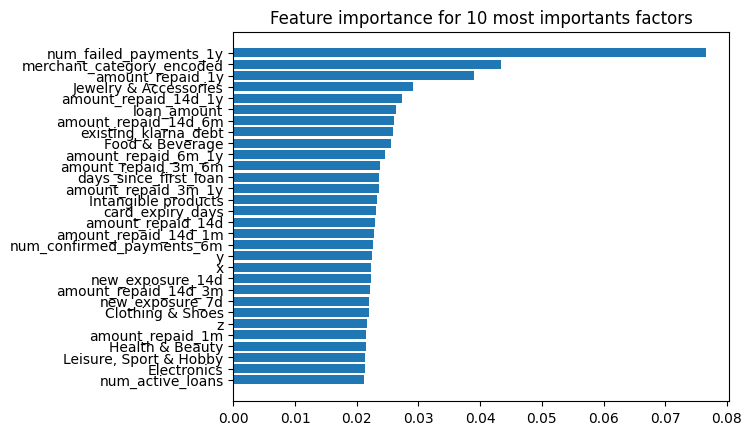

In [493]:
sorted_idx = clf.feature_importances_.argsort()
sorted_cols = X_dev.columns[sorted_idx]
plt.barh(sorted_cols[-30:], clf.feature_importances_[sorted_idx][-30:])
plt.title("Feature importance for 10 most importants factors")

In [503]:
explainer = shap.Explainer(clf)
shap_values = explainer(X_val)
shap_df = pd.DataFrame(shap_values.values, columns=X_val.columns)
shap_importance = shap_df.abs().mean().sort_values(ascending=False)
print(shap_importance)


amount_repaid_1y             0.380984
loan_amount                  0.250517
merchant_category_encoded    0.243171
card_expiry_days             0.204864
days_since_first_loan        0.187198
num_failed_payments_1y       0.162026
y                            0.159816
x                            0.158542
amount_repaid_6m             0.154652
z                            0.141711
existing_klarna_debt         0.130987
num_confirmed_payments_6m    0.115545
amount_repaid_3m             0.103200
amount_repaid_6m_1y          0.100846
amount_repaid_14d            0.092676
amount_repaid_14d_3m         0.086421
new_exposure_7d              0.081137
amount_repaid_1m             0.079113
amount_repaid_3m_6m          0.070821
num_confirmed_payments_3m    0.067436
amount_repaid_14d_6m         0.063219
amount_repaid_3m_1y          0.060864
amount_repaid_14d_1y         0.054833
new_exposure_14d             0.049606
num_active_loans             0.044122
amount_repaid_14d_1m         0.043130
new_exposure

#### Final shortlists consist of following variables:

In [508]:
sorted_cols[-18:]

Index(['num_confirmed_payments_6m', 'amount_repaid_14d_1m',
       'amount_repaid_14d', 'card_expiry_days', 'Intangible products',
       'amount_repaid_3m_1y', 'days_since_first_loan', 'amount_repaid_3m_6m',
       'amount_repaid_6m_1y', 'Food & Beverage', 'existing_klarna_debt',
       'amount_repaid_14d_6m', 'loan_amount', 'amount_repaid_14d_1y',
       'Jewelry & Accessories', 'amount_repaid_1y',
       'merchant_category_encoded', 'num_failed_payments_1y'],
      dtype='object')

# 6. Model

In [510]:
X_dev = X_dev[sorted_cols[-18:]]
X_val = X_val[sorted_cols[-18:]]

In [511]:
# hyperparameters space
space={'max_depth': hp.choice("max_depth", np.arange(2, 5, 1)),
        'reg_alpha' : hp.choice('reg_alpha', np.linspace(0.2, 4, 20, dtype = float)),
        'learning_rate' : hp.uniform('learning_rate', 0.05, 0.25),
        'colsample_bytree' : hp.choice('colsample_bytree', np.linspace(0.6, 1, 10, dtype = float)),
        'min_child_weight' : hp.choice('min_child_weight', np.arange(1, 35, 5)),
        'n_estimators': hp.choice('n_estimators', np.arange(700, 701, 50)),
        'gamma': hp.choice('gamma', np.linspace(0.2, 4, 20, dtype = float)),
        'scale_pos_weight' : hp.choice('scale_pos_weight', np.array([1, 5, 20, 50], dtype = int))
    }

In [542]:
def objective(space):
    with mlflow.start_run(nested=True):
        mlflow.set_tag('pd_model', 'Xgboost')
        mlflow.log_params(space)
        
        clf=xgb.XGBClassifier(n_estimators =space['n_estimators'],
                              max_depth = space['max_depth'], 
                              gamma = space['gamma'],                    
                              reg_alpha = space['reg_alpha'],
                              min_child_weight = space['min_child_weight'],
                              colsample_bytree = space['colsample_bytree'],
                              learning_rate = space['learning_rate'],
                              scale_pos_weight = space['scale_pos_weight'],
                              tree_method = 'hist', 
                              random_state = 42,
                              eval_metric="auc",
                              early_stopping_rounds = 15
                             )

        evaluation = [(X_val, y_val)]
        
        clf.fit(X_dev, y_dev,
                eval_set=evaluation, verbose = False)
        pred = clf.predict_proba(X_val).T[1]
        pred_d = clf.predict_proba(X_dev).T[1]
        auc_test = roc_auc_score(y_val, pred)
        auc_train = roc_auc_score(y_dev, pred_d)  
        
        mlflow.log_metric('auc_test', auc_test)
        mlflow.log_metric('auc_train', auc_train)
        return {'loss': -roc_auc, 'params': space, 'status': STATUS_OK }

In [545]:
mlflow.set_experiment('klarna_final')

2025/07/25 00:36:17 INFO mlflow.tracking.fluent: Experiment with name 'klarna_final' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///C:/Users/radkr/mlruns/197349562302119142', creation_time=1753396577910, experiment_id='197349562302119142', last_update_time=1753396577910, lifecycle_stage='active', name='klarna_final', tags={}>

In [546]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 200,
                        trials = trials)

100%|█████████████████████████████████████████████| 200/200 [04:13<00:00,  1.27s/trial, best loss: -0.9748817342154963]


Based on predictive performance on test set and taking under consideration size of the model (depth, number of variables and trees) the based combination of hyperparameters were chosen and listed below. This hyperparameters will be used to train our final model.

In [547]:
best_params = {'colsample_bytree': 0.6444444444444444, 
               'gamma': 0.4, 
               'learning_rate': 0.07234913641176433, 
               'max_depth': 2, 
               'min_child_weight': 21, 
               'n_estimators': 700, 
               'reg_alpha': 1.7999999999999998, 
               'scale_pos_weight': 1,
               'tree_method': 'hist',
               'early_stopping_rounds': 15
              }

In [549]:
clf = xgb.XGBClassifier(**best_params, random_state = 42, eval_metric = 'auc')

evaluation = [(X_val, y_val)]
clf.fit(X_dev, y_dev,
                eval_set=evaluation, verbose = True)
pred = clf.predict_proba(X_val).T[1]
pred_d = clf.predict_proba(X_dev).T[1]
auc_test = roc_auc_score(y_val, pred)
auc_train = roc_auc_score(y_dev, pred_d)  
print(f"FINAL_AUC: {auc_test:.4f}")
print(f"FINAL_GINI: {2 * auc_test - 1:.4f}")


[0]	validation_0-auc:0.62130
[1]	validation_0-auc:0.64587
[2]	validation_0-auc:0.65030
[3]	validation_0-auc:0.65787
[4]	validation_0-auc:0.65658
[5]	validation_0-auc:0.65873
[6]	validation_0-auc:0.65661
[7]	validation_0-auc:0.65825
[8]	validation_0-auc:0.66320
[9]	validation_0-auc:0.66348
[10]	validation_0-auc:0.66393
[11]	validation_0-auc:0.66612
[12]	validation_0-auc:0.66620
[13]	validation_0-auc:0.67080
[14]	validation_0-auc:0.67289
[15]	validation_0-auc:0.67382
[16]	validation_0-auc:0.67372
[17]	validation_0-auc:0.67458
[18]	validation_0-auc:0.67470
[19]	validation_0-auc:0.67496
[20]	validation_0-auc:0.67526
[21]	validation_0-auc:0.67622
[22]	validation_0-auc:0.67586
[23]	validation_0-auc:0.67570
[24]	validation_0-auc:0.67588
[25]	validation_0-auc:0.67642
[26]	validation_0-auc:0.67756
[27]	validation_0-auc:0.67768
[28]	validation_0-auc:0.67776
[29]	validation_0-auc:0.67804
[30]	validation_0-auc:0.67811
[31]	validation_0-auc:0.67935
[32]	validation_0-auc:0.68004
[33]	validation_0-au

In [551]:
final_df[sorted_cols[-18:]]

,num_confirmed_payments_6m,amount_repaid_14d_1m,amount_repaid_14d,card_expiry_days,Intangible products,amount_repaid_3m_1y,days_since_first_loan,amount_repaid_3m_6m,amount_repaid_6m_1y,Food & Beverage,existing_klarna_debt,amount_repaid_14d_6m,loan_amount,amount_repaid_14d_1y,Jewelry & Accessories,amount_repaid_1y,merchant_category_encoded,num_failed_payments_1y
0,36,0.441271,6875,953.0,0,0.278101,717,0.623545,0.445999,0,21098.0,0.101285,5300,0.045173,0,152193,0.044275,0
1,0,0.000000,0,1348.0,0,0.000000,-1,0.000000,0.000000,0,NaN,0.000000,9547,0.000000,0,0,0.037220,0
2,0,0.000000,0,151.0,0,0.000000,-1,0.000000,0.000000,0,NaN,0.000000,5948,0.000000,0,0,0.054595,0
3,0,0.000000,0,897.0,0,0.000000,0,0.000000,0.000000,0,31742.0,0.000000,15871,0.000000,0,0,0.085583,0
4,26,0.465071,6511,1036.0,0,0.277083,501,0.520849,0.531983,0,9064.0,0.105028,19510,0.055873,0,116532,0.039770,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111897,3,0.500145,1724,1536.0,1,1.000000,35,1.000000,1.000000,0,3448.0,0.325099,12360,0.325099,0,5303,0.046574,0
111898,0,0.000000,0,1246.0,0,0.000000,-1,0.000000,0.000000,0,NaN,0.000000,6449,0.000000,0,0,0.054595,0
111899,12,0.067067,647,571.0,0,0.630673,208,0.747508,0.843700,0,3884.0,0.023707,2808,0.020001,0,32348,0.054595,0
111900,4,0.499723,11708,1336.0,0,0.233790,509,1.000000,0.233790,0,46838.0,0.499723,21938,0.116830,1,100214,0.062147,0


In [552]:
scores = clf.predict_proba(final_df[sorted_cols[-18:]]).T[1]


In [555]:
final_df['score'] = scores

In [561]:
print(f"GINI DEV: {2 * roc_auc_score(final_df[final_df['sample'] == 'DEV']['target'], final_df[final_df['sample'] == 'DEV']['score']) - 1}")
print(f"GINI VAL: {2 * roc_auc_score(final_df[final_df['sample'] == 'VAL']['target'], final_df[final_df['sample'] == 'VAL']['score']) - 1}")
print(f"GINI OOT: {2 * roc_auc_score(final_df[final_df['sample'] == 'OOT']['target'], final_df[final_df['sample'] == 'OOT']['score']) - 1}")

GINI DEV: 0.4168077892973252
GINI VAL: 0.40310230783934387
GINI OOT: 0.3760118416203453


# 7. Explainability

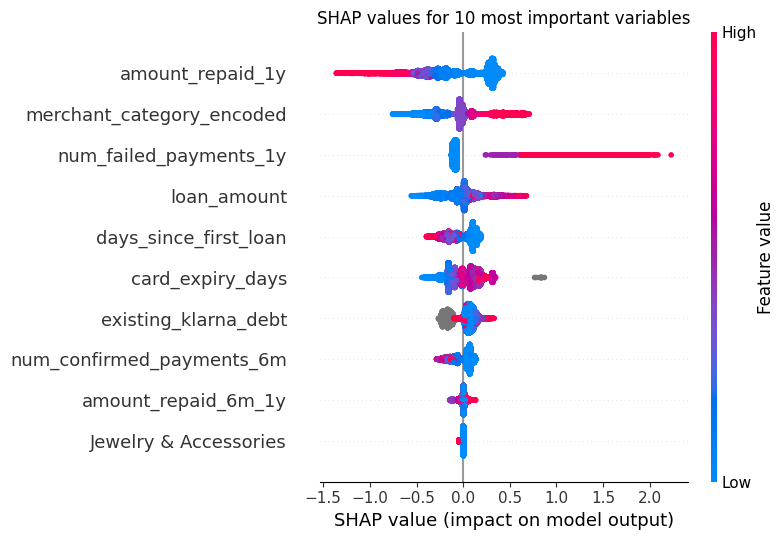

In [566]:
explainer = shap.TreeExplainer(clf)
imp = feature_importance(clf)
top_columns = list(imp.index[:10])
shap_values = explainer.shap_values(final_df[final_df['sample'] == 'OOT'][sorted_cols[-18:]], y=final_df[final_df['sample'] == 'OOT']['target'])
sh = pd.DataFrame(shap_values, columns=sorted_cols[-18:])
plt.title("SHAP values for 10 most important variables")
shap.summary_plot(sh[top_columns].values, final_df[final_df['sample'] == 'OOT'][sorted_cols[-18:]][top_columns])    

In [571]:
X_oot = final_df[final_df['sample'] == 'OOT'][sorted_cols[-18:]]
y_oot = final_df[final_df['sample'] == 'OOT']['target']

In [710]:
X_oot.head(1)

,num_confirmed_payments_6m,amount_repaid_14d_1m,amount_repaid_14d,card_expiry_days,Intangible products,amount_repaid_3m_1y,days_since_first_loan,amount_repaid_3m_6m,amount_repaid_6m_1y,Food & Beverage,existing_klarna_debt,amount_repaid_14d_6m,loan_amount,amount_repaid_14d_1y,Jewelry & Accessories,amount_repaid_1y,merchant_category_encoded,num_failed_payments_1y
5,8,0.0,0,699.0,0,0.0,546,0.0,0.192585,0,0.0,0.0,38305,0.0,0,79892,0.044275,0


In [711]:
calibrator.predict(clf.predict_proba(X_oot.head(1)).T[1])

array([0.02347341], dtype=float32)

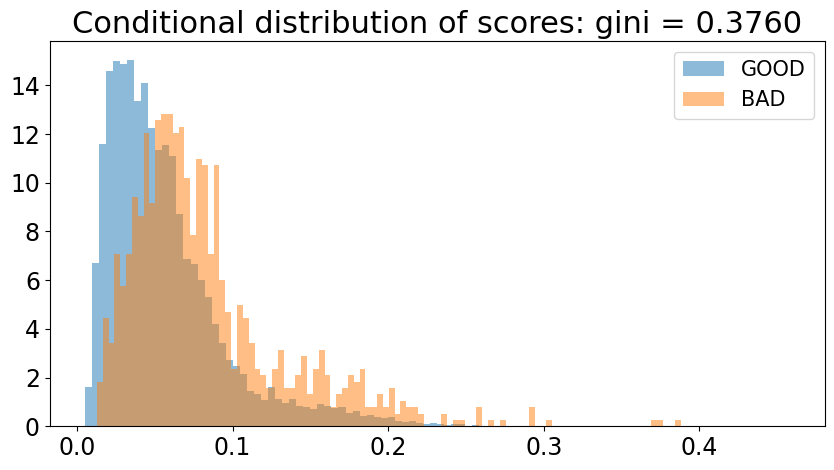

In [574]:
pred_xgb = clf.predict_proba(X_oot).T[1]
fpr, tpr, thresholds = roc_curve(y_oot, pred_xgb)
roc_auc = auc(fpr, tpr)
gini = 2 * roc_auc - 1
flag_list = ["good", "bad"]
plt.figure(figsize = (10, 5))
for i, flag in enumerate(flag_list): 
    plt.hist(pred_xgb[y_oot == i], alpha = 0.5, bins = 100, label = flag.upper(), density = True)
plt.xticks(fontsize = 17)
plt.yticks(fontsize = 17)
plt.title(f"Conditional distribution of scores: gini = {gini:.4f}", fontsize = 22)
plt.legend(prop = {"size": 15})
plt.show()

# 8. Calibration

We use whole dataset for calibration

In [581]:
calibrator = IsotonicRegression(out_of_bounds='clip')
calibrator.fit(final_df['score'], final_df['target'])

final_df['proba'] = calibrator.predict(final_df['score'])

In [583]:
print(f"GINI DEV: {2 * roc_auc_score(final_df[final_df['sample'] == 'DEV']['target'], final_df[final_df['sample'] == 'DEV']['proba']) - 1}")
print(f"GINI VAL: {2 * roc_auc_score(final_df[final_df['sample'] == 'VAL']['target'], final_df[final_df['sample'] == 'VAL']['proba']) - 1}")
print(f"GINI OOT: {2 * roc_auc_score(final_df[final_df['sample'] == 'OOT']['target'], final_df[final_df['sample'] == 'OOT']['proba']) - 1}")

GINI DEV: 0.4187882916478538
GINI VAL: 0.40649178277281006
GINI OOT: 0.37981082639373964


In [653]:
def plot_hist(df, n_bins, target, score):
    fig, ax = plt.subplots()
    ax.hist(df[df[target] == 0][score], bins = n_bins, alpha = 0.5, color = 'r', label = score)
    ax.hist(df[df[target] == 0]["proba"], bins = n_bins, alpha = 0.5, color = 'blue', label = 'iso')
    ax.set_xlim(0, 1)
    ax.set_label('Score/Probability')
    ax.set_title('Distribution [pre (score) vs post (iso) calibration]')
    ax.grid()
    
    fig.text(
        0.5, 0.01, f"*bins={n_bins}", ha='center', fontsize= 'small', style = 'italic'
    )
    plt.legend()
    plt.tight_layout(rect=[0, 0.02, 1, 1])
    

def plot_calibration_with_hist(df, n_bins, strategy, strategy_desc, target, score):
    y_true = df[target]
    y_prob = df['proba']
    y_score = df[score]
    
    prob_true, prob_pred = calibration_curve(
        y_true, y_prob, n_bins = n_bins, strategy = strategy
    )
    score_true, score_pred = calibration_curve(
        y_true, y_score, n_bins = n_bins, strategy = strategy
    )
    fig, ax = plt.subplots()
    
    ax.hist(
        y_prob,
        weights=np.ones_like(y_prob) * 3 / len(y_prob),
        alpha = 0.3, 
        bins = np.maximum(10, n_bins),
        color = 'r'
    )
    ax.hist(
        y_score,
        weights=np.ones_like(y_score) * 3 / len(y_score),
        alpha = 0.3, 
        bins = np.maximum(10, n_bins),
        color = 'blue'
    )
    ax.plot([0, 1], [0,1], ":", c="k")
    ax.plot(score_pred, score_true, marker = "o", markersize = 4, color ="blue", alpha = 0.5, label=score)
    ax.plot(prob_pred, prob_true, marker = "o", markersize = 4, color ="r", alpha = 0.5, label='iso')
    
    ax.set_xlabel('Average Score/Prob')
    ax.set_ylabel("Average BR")
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set(aspect='equal')
    ax.set_title("Calibration plot with score distribution")
    ax.legend(loc='upper left')
    ax.grid()
    fig.text(
        0.5, 0.01, f"*bins={n_bins} {strategy_desc}", ha='center', fontsize= 'small', style = 'italic'
    )
    plt.tight_layout(rect=[0, 0.02, 1, 1])
    


def plot_calibration_with_bins(df, n_bins, strategy, strategy_desc, target, score):
    if strategy == 'uniform':
        df['cut'] = pd.cut(df[score], bins = n_bins, duplicates = 'drop')
    elif strategy == 'quantile':
        df['cut'] = pd.qcut(df[score], q=n_bins, duplicates = 'drop')
    df['mid'] = pd.to_numeric(df['cut'].apply(lambda x: 0 if x.mid <0 else x.mid))
    dummy = pd.DataFrame(df.groupby('mid')['mid'].mean().rank())
    dummy.columns = ['rank']
    df_final = pd.merge(df, dummy.reset_index(), on = 'mid')
    df_final_agg = (
        df_final.groupby(['rank', 'mid'])[[target, score, 'proba']].mean().reset_index()
    )
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5), sharey = True)
    ax1.plot([0,1], [0,1], linestyle = '--', label = 'Perfect Calibration', color='black')
    ax1.plot(
        df_final_agg[target], df_final_agg['proba'], marker = ".", label='iso', color ='r'
    )
    ax1.plot(
        df_final_agg[target], df_final_agg[score], marker = ".", label='iso', color ='blue'
    )
    ax1.legend(loc='upper left')
    ax1.set_xlabel('Average BR')
    ax1.set_ylabel("Average Score/Prob")
    ax2.tick_params(labelleft=True)
    ax1.grid()
    ax1.set_xlim(0, 0.3)
    # ax1.set_ylim(0, 0.3)
    
    ax2.plot(df_final_agg['rank'], df_final_agg[target], marker ='.', label = 'Perfect Calibration', color = 'black')
    ax2.plot(
        df_final_agg['rank'], df_final_agg['proba'], marker = ".", label='iso', color ='r'
    )
    ax2.plot(
        df_final_agg['rank'], df_final_agg[score], marker = ".", label=score, color ='blue'
    )   
    ax2.legend(loc='upper left')
    ax2.set_xlabel('Bin No.')
    ax2.set_ylabel("Average Score/Prob/BR")
    ax2.grid()
        
    fig.text(
        0.5, 0.01, f"*bins={n_bins}", ha='center', fontsize= 'small', style = 'italic'
    )
    # plt.tight_layout(rect=[0, 0.02, 1, 0])
    plt.suptitle('Calibration Curves')
    


def plot_calibration_with_areas(df, n_bins, strategy, strategy_desc, target, score):
    x, y = calibration_curve(
        df[target], df[score], n_bins = n_bins, strategy = strategy
    )
    fig, ax = plt.subplots()
    ax.plot(x, y, marker ='.', markersize =5, label = 'Calibration Curve', color = 'blue')
    ax.plot([0,1], [0,1], linestyle = '--', label = 'Perfect Calibration', color='black')    
    
    ax.fill_between(
        x, x, y, 
        where =(x>y),
        color ='red',
        alpha=0.3,
        interpolate = True,
        label = 'Underestimated Risk'
    )
    ax.fill_between(
        x, x, y, 
        where =(x<=y),
        color ='green',
        alpha=0.3,
        interpolate = True,
        label = 'Underestimated Risk'
    )
    ax.set_xlim(0, 0.3)
    ax.set_ylim(0, 0.3)
    ax.legend(fontsize=8)
    ax.set_xlabel('Average BR')
    ax.set_ylabel("Average Score")
    ax.set_title('Calibration plot of the model')
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)   
    plt.grid()
    fig.text(
        0.5, 0.01, f"*bins={n_bins}", ha='center', fontsize= 'small', style = 'italic'
    )
    plt.tight_layout(rect=[0, 0.02, 1, 1])



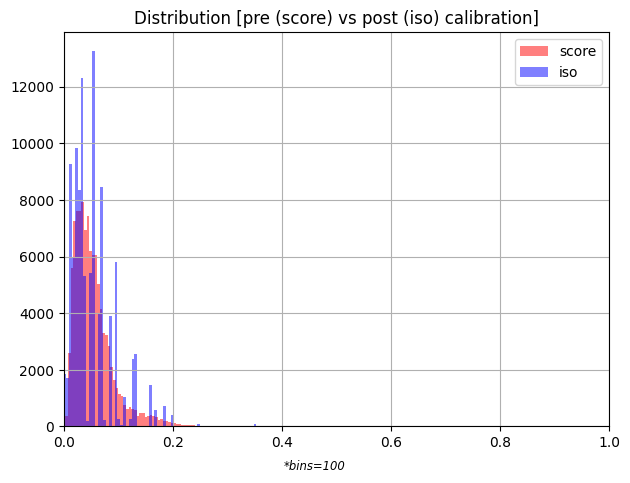

In [596]:
plot_hist(final_df, 100, "target", "score")

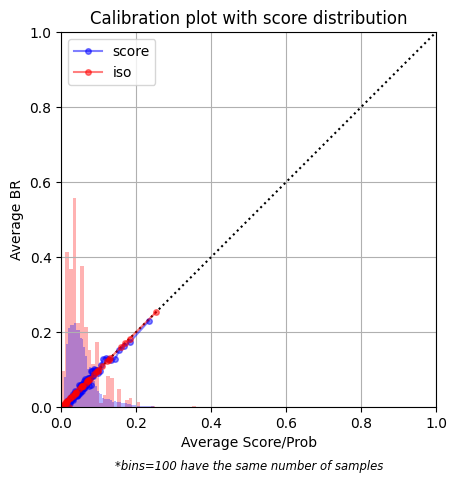

In [605]:
plot_calibration_with_hist(final_df, 100, 'quantile', 'have the same number of samples', 'target', 'score')

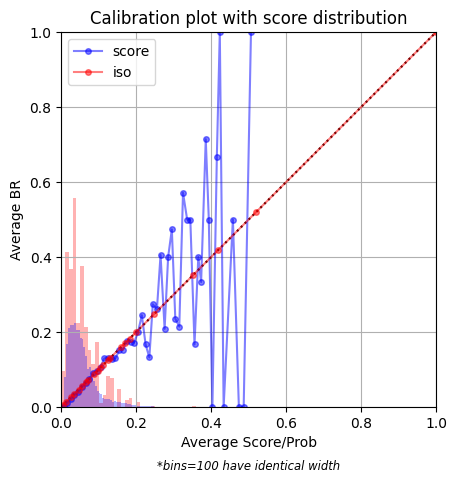

In [604]:
plot_calibration_with_hist(final_df, 100, 'uniform', 'have identical width', 'target', 'score')

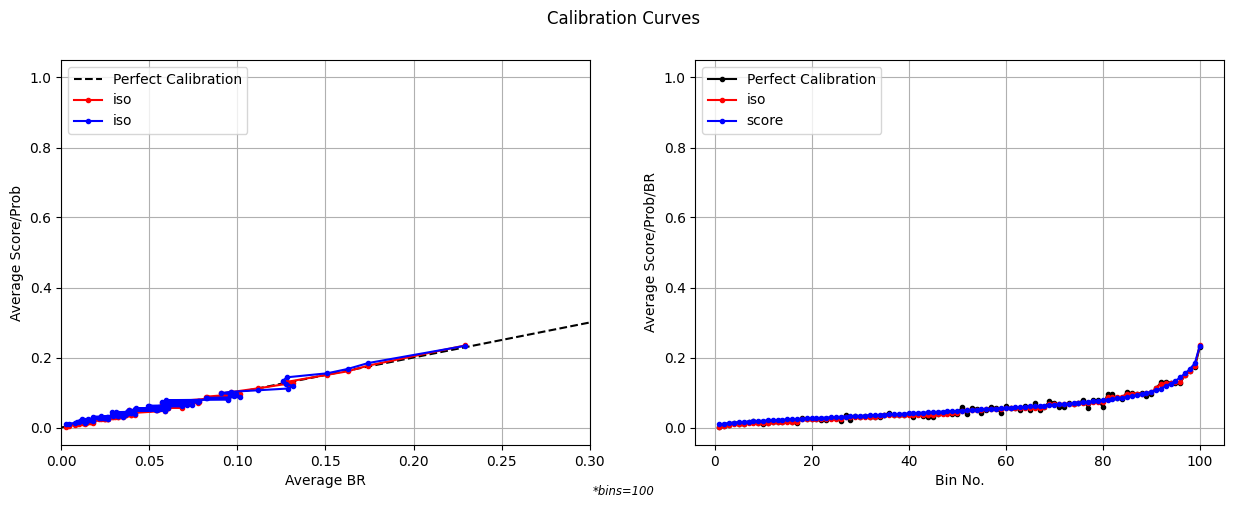

In [652]:
plot_calibration_with_bins(final_df, 100, 'quantile', 'have the same number of samples', 'target', 'score')

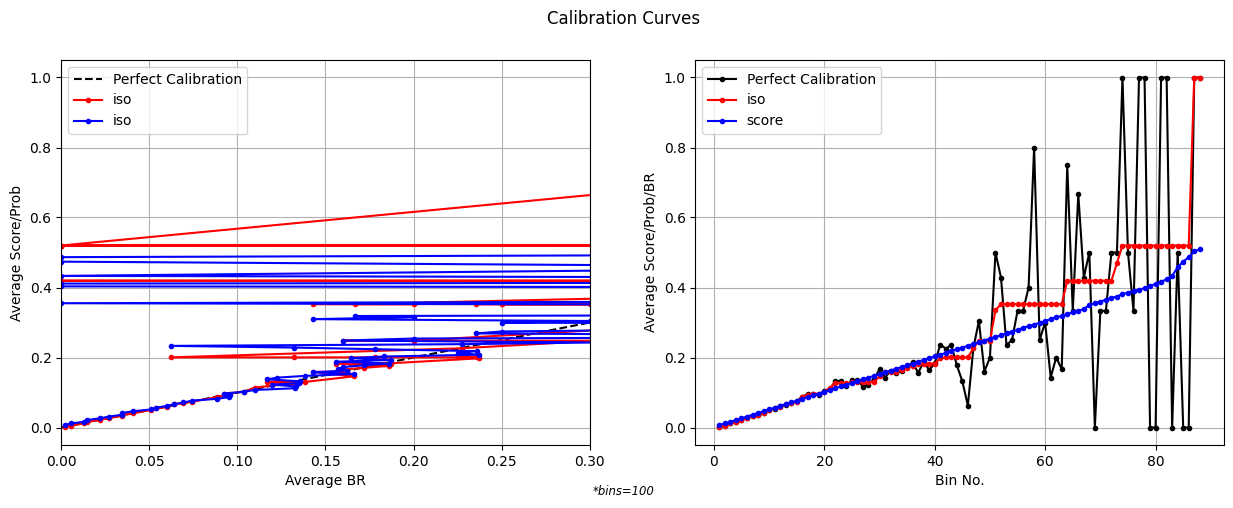

In [651]:
plot_calibration_with_bins(final_df, 100, 'uniform', 'have identical width', 'target', 'score')

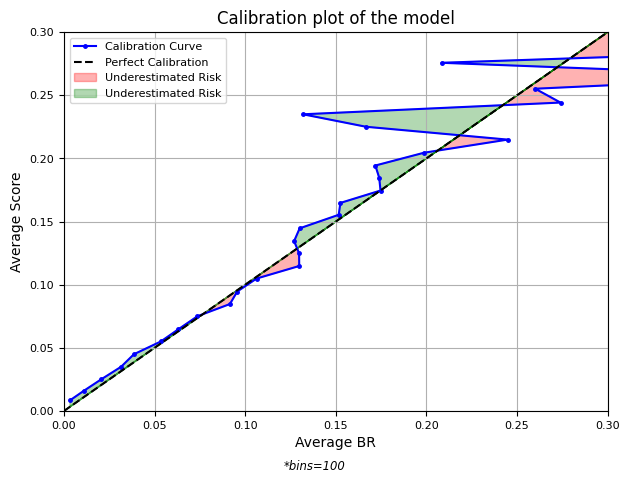

In [643]:
plot_calibration_with_areas(final_df, 100, 'uniform', 'have identical width', 'target', 'score')

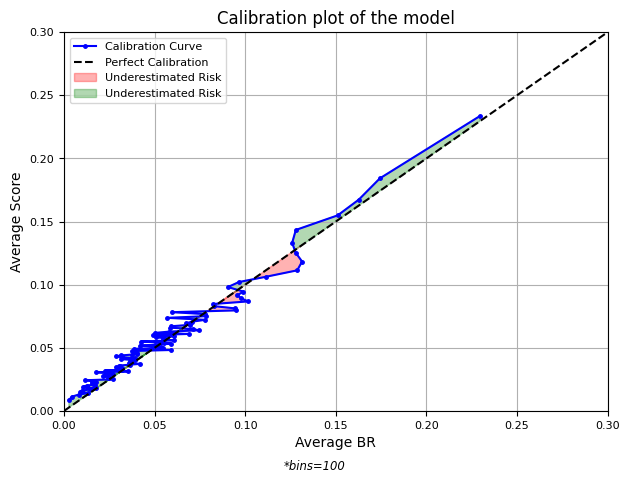

In [642]:
plot_calibration_with_areas(final_df, 100, 'quantile', 'have the same number of samples', 'target', 'score')

# Save model

In [657]:
import joblib

In [658]:
with open(r'C:\Users\radkr\klarna\model.pkl', 'wb') as f:
    joblib.dump(clf, f)

In [660]:
with open(r'C:\Users\radkr\klarna\calibrator.pkl', 'wb') as f:
    joblib.dump(calibrator, f)
with open(r'C:\Users\radkr\klarna\encoder.pkl', 'wb') as f:
    joblib.dump(target_enc, f)

Test

In [662]:
with open(r'C:\Users\radkr\klarna\model.pkl', 'rb') as f:
    model = joblib.load(f)
with open(r'C:\Users\radkr\klarna\calibrator.pkl', 'rb') as f:
    calibrator = joblib.load(f)
with open(r'C:\Users\radkr\klarna\encoder.pkl', 'rb') as f:
    encoder = joblib.load(f)